In [164]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [165]:
# function takes result file and returns GO_ID and array of coefficients
def get_coeff(input_file):
    results = open(input_file)
    read_coeff = 0
    read_perfo = 0
    coeffs = []
    tissues = []
    pred = []
    label = []
    tissueMap = {}
    for line in results:
        data = line.rstrip('\n').split('\t')
        # print data[0]
        if data[0] == '# Prediction results for:':
            GO_ID = data[1]    
        elif data[0] == '# ROC AUC score:':
            AUC = float(data[1])
        elif data[0] == '# tissue':
            tissues.append(data[2])
            tissueMap[data[2]] = []
        elif data[0] == '# Coefficients:':
            read_coeff = 1
            i = 0      
        elif data[0] == '# Gene ID':
            read_coeff = 0
            read_perfo = 1
        elif read_perfo == 1 and (data[0]):
            label.append(data[1])
            pred.append(data[2])
        elif read_coeff == 1 and (data[0]):
            t_idx = int(data[0])-1
            coeff = float(data[1])
            tissueMap[tissues[t_idx]].append(coeff) 
    results.close()
    # print GO_ID,'AUC:', AUC
    return [GO_ID, tissueMap, AUC, label, pred]

def load_all_go(input_file):
    GO_list = []
    gene_count = []
    results = open(input_file)
    skip = 2
    i_line = 0
    for line in results:
        if i_line < skip:
            i_line += 1
            continue
        data = line.rstrip('\n').split('\t')
        GO_list.append(data[0])
        gene_count.append(int(data[1]))
    results.close()
    return [GO_list, gene_count]



In [166]:
# function takes GO term, array of coefficients, and (optional) highlighted tissues, and plots accordingly
def plot_coeff(GO_ID, nGenes, AUC, tissueMap, highlight = []):
    # samples = open('../data/samples_to_tissues_map.txt')
    # tissue_type = np.loadtxt(samples,dtype='S40',delimiter='\t')
    # tissue_list = pd.unique(tissue_type[:,2]) # pandas maintains correct order, numpy doesn't
    
    tissue_list = []
    coeffs = []
    x = []
    for index, key in enumerate(sorted(tissueMap)):
        tissue_list.append(key)
        for coeff in tissueMap[key]:
            coeffs.append(abs(coeff))
            x.append(index)
    
    # x = [np.where(tissue_list == tissue)[0][0] for tissue in tissue_type[:,2]]
    plt.figure(figsize=(18, 6))
    plt.plot(x, coeffs, 'bo')
    plt.margins(0.01)
    ax = plt.gca()
    ax.xaxis.grid(which='both')
    # You can specify a rotation for the tick labels in degrees or with keywords.
    plt.xticks(range(len(tissue_list)), tissue_list, rotation='vertical')
    # Pad margins so that markers don't get clipped by the axes
    
    # Tweak spacing to prevent clipping of tick-labels
    # plt.subplots_adjust(bottom=0.15)
    plt.ylabel((GO_ID+'('+str(nGenes)+' genes) - AUC:'+str(AUC)))
    plt.show()
    
    """
    tissue_type = np.zeros((8555,3),dtype=np.str)
    row = -1
    
    for sample in samples:
        if row < 0:
            row = row + 1
            continue
        tissue_type[row,:] = sample.split('\t')
    print tissue_type
    """

 GO:0019221  # of genes: 373 AUC: 0.6311967


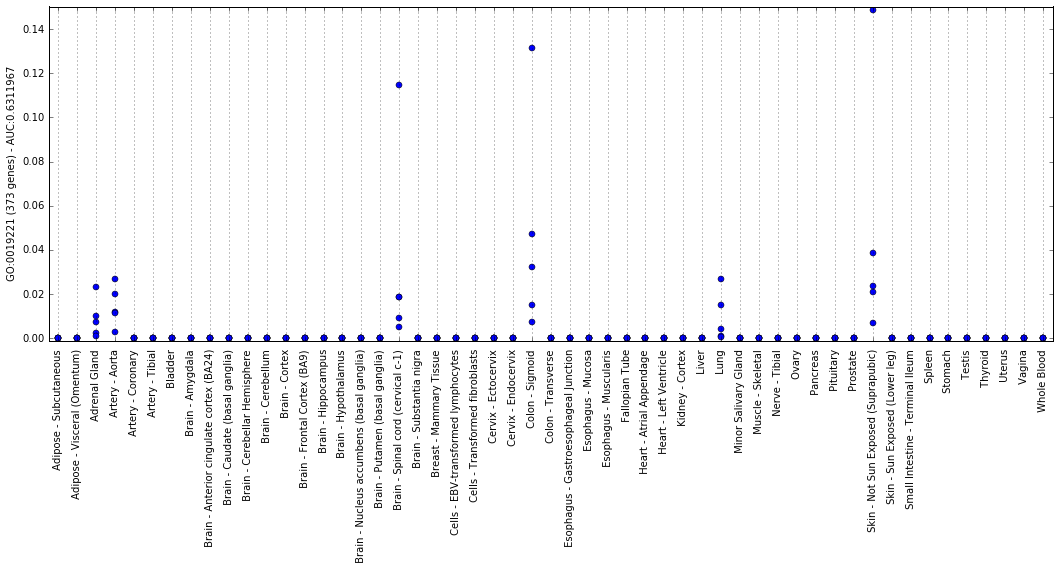

 GO:0051960  # of genes: 349 AUC: 0.5933932


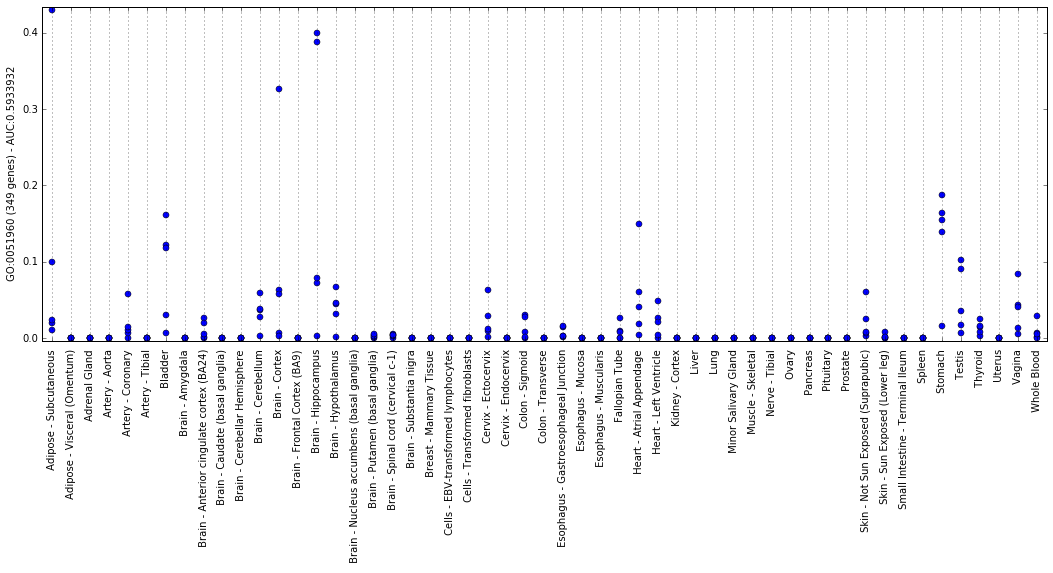

 GO:0050767  # of genes: 321 AUC: 0.6069383


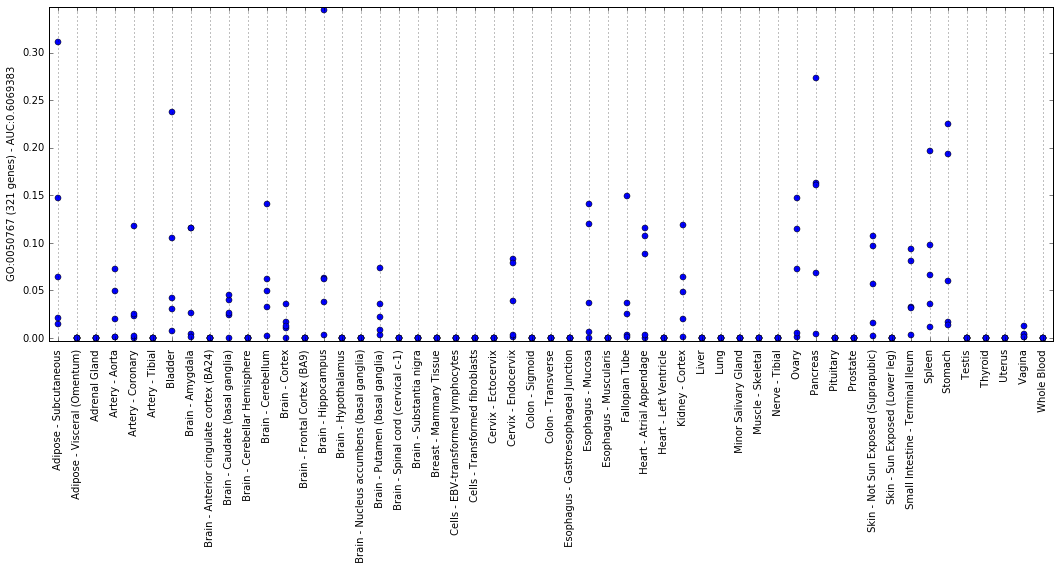

In [169]:
GO_list, gene_counts = load_all_go('../data/GO_terms_final_gene_counts.txt')
for i in range(4,7):
    input_name = '../data/grplasso_results/grplasso_'+GO_list[i]+'_0.txt'
    [GO_ID, tissueMap, AUC, label, pred] = get_coeff(input_name)
    print GO_ID,'# of genes:',gene_counts[i],'AUC:', AUC
    plot_coeff(GO_ID, gene_counts[i], AUC, tissueMap)